# Manufacturing
## Time to failure since repair

In manufacturing machine failure means less production, potentially unforeseen expenses, and consequently less revenue. Hence as a manufacturer we want to find ways to predict and reduce machine failure. This can be achieved by estimating *time to failure since repair*. 

Imagine a car. Throughout its lifetime it undergoes a series of repairs. Each time it undergoes a repair it becomes censored, and we restart the clock. At some point in this cycle the car may finally break (face the event). 

TIME = 0 ###### TIME = 75 CLUTCH CHANGE (BECOMES CENSORED)\
TIME = 0 ############ TIME = 150 TRANSMISSION CHANGE (BECOMES CENSORED)\
TIME = 0 #################### TIME = 200 MOTOR CHANGE (BECOMES CENSORED)\
TIME = 0 ########## TIME = 100 BEYOND REPAIR (EVENT REACHED)

Some cars don't break after, e.g. 10 years, and you get a new one (they are "cured"). 

We can estimate time to failure since repair using apd-crs, incorporating the idea that some machines are resilient and don’t fail before they’re replaced.


## The manufacturing dataset

- For illustration we use the following data set borrowed from the PySurvival library. 
- A manufacturing plant may have several machines of a certain type. 
- Each machine instance can undergo many repairs over the course of its tenure. 
- This would lead to a multitude of censored observations for time since repair, with each specific machine likely contributing to several observations, since it may be repaired more than once during its tenure.
- Each machine has associated covariates like pressure index, moisture index, the team working with it, etc.
- After preprocessing the data, we would obtain a table like the one below.



In [7]:
import pandas as pd 
import numpy as np

url = 'https://raw.githubusercontent.com/square/pysurvival/master/pysurvival/datasets/maintenance.csv'
data = pd.read_csv(url, sep=';')
data.rename(columns={'lifetime': 'time_since_repair'}, inplace=True)
data

,time_since_repair,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1
...,...,...,...,...,...,...,...
995,88,1,88.589759,112.167556,99.861456,TeamB,Provider4
996,88,1,116.727075,110.871332,95.075631,TeamA,Provider4
997,22,0,104.026778,88.212873,83.221220,TeamB,Provider1
998,78,0,104.911649,104.257296,83.421491,TeamA,Provider4


## Data Preprocessing


In [8]:
#Relabl: 2="censored" and 1="not cured"

def convert(row):
    if row==0:
        return 2
    return 1

data['broken'] = data['broken'].apply(lambda x:convert(x) ) 

In [9]:
#Convert object columns to categorical so we can us sksurv one-hot encoder
for col in ['team', 'provider']:
    data[col] = data[col].astype('category')

In [10]:
#Test train split
from sklearn.model_selection import train_test_split
training_data, test_data, training_labels, test_labels, training_times, test_times = train_test_split(
    data.drop(columns=['broken', 'time_since_repair']), data['broken'], data['time_since_repair'], test_size=0.33)

In [11]:
#Perform one-hot encoding
from sksurv.preprocessing import OneHotEncoder
ohc = OneHotEncoder()
training_data = ohc.fit_transform(training_data)
test_data = ohc.transform(test_data)

In [12]:
#Scale
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
training_data = scaler.fit_transform(training_data)
test_data = scaler.transform(test_data)


## Using the SurvivalAnalysis class

In [13]:
#Instantiate the SurvivalAnalysis class
from apd_crs.survival_analysis import SurvivalAnalysis

In [23]:
model = SurvivalAnalysis('clustering') #Use Kmeans clustering to assign cure
#labels prior to fitting with logistic regression for cure probability
model.survival_fit(training_data, training_labels, training_times, pu_kmeans_init=20)
#pu_kmeans is number of Kmeans initializations to try 

## Evaluating Model Performance

### Danger (aka Risk)

The Hazard for susceptible (noncured) individuals is given by

$h(t, x, \gamma) = {\mbox{Baseline Hazard}}(t)\exp(\gamma x)$ 

where 

$\gamma, x = \mbox{covariate weight vector}, \mbox{covariate vector}.$

This motivates us to define the danger associated with an individual having covariate vector $x$ as

$\mbox{Danger}(x) = w_1 (\gamma\cdot x )+ w_2 (1-\pi(x))$ 

where $w_1, w_2\in [0,1]$, $w_1+w_2=1$, and $\pi(x)$ is the probability of cure. 

Optimal weights can be chosen through cross validation.

### Concordance Index (C-Index)

Two individuals are comparable if one experiences the event before the other. 

A pair of individuals is concordant if the one which "died" first has a higher danger.

C-Index = ratio of concordant pairs to comparable pairs.

Clearly C-index is in $[0,1]$ and the higher the better. 

Random guessing $\Rightarrow$ C-index = 0.5

In [24]:
train_danger =\
(np.dot(training_data, model.gamma_) +\
 np.log(model.predict_cure_proba(training_data,training_labels)[:,1]))

In [25]:
test_danger =\
(np.dot(test_data, model.gamma_) +\
 np.log(model.predict_cure_proba(test_data, test_labels)[:,1]))

In [26]:
#We can check for correlation with the hazard for 
#the susceptibles (not cured) are probability of being susceptible
noncure_probs = model.predict_cure_proba(training_data, training_labels)[:,1]
hazard_riskfactor = np.dot(training_data, model.gamma_)
np.corrcoef(noncure_probs, hazard_riskfactor)

array([[1.        , 0.28038425],
       [0.28038425, 1.        ]])

## Evaluating Model Performance

### The C-Index

In [27]:
train_score = model.cindex(training_times, training_labels, train_danger) 

print(f"c-index score on train set is {train_score}")

c-index score on train set is (0.8746103125775926, 31702, 4545, 0, 671)


In [28]:
test_score = model.cindex(test_times, test_labels, test_danger) 

print(f"c-index score on test set is {test_score}")

c-index score on test set is (0.8934760910988113, 9847, 1174, 0, 209)


### Overall Risk factors

<AxesSubplot:>

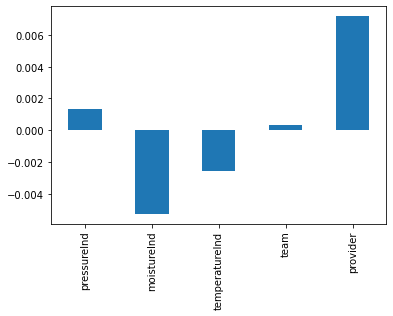

In [29]:
features = [col for col in data.columns if col not in ['broken', 'time_since_repair']]
feats = {col:model.gamma_[i] for (i,col) in enumerate(features)}
feats = pd.Series(feats)
feats.plot.bar()

### Individual Predictions

In [30]:
#Overall survivor function:

#We can plot the overall survival function for e.g. the first five indiduals in the test set.

TIMES = np.arange(1, 93, 0.5)
repeats_array = np.tile(TIMES, (len(test_data), 1))
ovpr = model.predict_overall_survival(test_data, repeats_array, test_labels)

#We can include the corresponding probabilities of cure in a legend
cure_probs =\
[np.around((model.predict_cure_proba(test_data, test_labels)[0:5,0])[i], decimals=2) for i in range(5)]

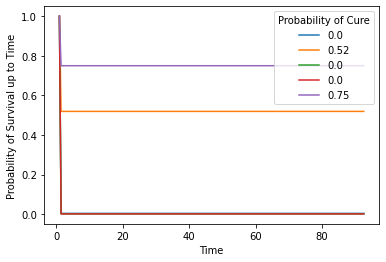

In [31]:
import matplotlib.pyplot as plt
y = ovpr[0:5,:]
x = TIMES
plt.plot(x, y.T, )
plt.xlabel('Time')
plt.ylabel('Probability of Survival up to Time')
plt.legend(labels=cure_probs, loc='upper right', title='Probability of Cure')
plt.show()